# DeepDream

We'll describe an implementation of DeepDream, a system that uses neural networks to generate dream-like images, showcasing how algorithms can reinterpret and morph visual content in surreal and artistic ways.

## Select Imput Image

We begin by loading the example image titled 'neuraltissue_with_colorlabels.png'. 

This image is sourced from the Drosophila ssTEM dataset, which is publicly available on Figshare: [Segmented anisotropic ssTEM dataset of neural tissue](https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713). This dataset provides a detailed view of neural tissue, aiding in the study of neural structures and patterns. The image can also be downloaded from the corresponding GitHub repository at [this link](http://github.com/unidesigner/groundtruth-drosophila-vnc), which offers additional resources and information related to the Drosophila ssTEM dataset.

In [1]:
from PIL import Image

im = Image.open("neuraltissue_with_colorlabels.png").convert('RGB').resize((256, 256))

The image is a part of the **Drosophila ssTEM dataset** and features a cross-section of neural tissue from a Drosophila melanogaster third instar larva ventral nerve cord. This high-resolution dataset is crucial for studying the details of neural structures and for the development of image segmentation algorithms.

Each image in the dataset, including the one provided, comes with a detailed segmentation of the neural tissue. In the images, various neural structures are labeled with different colors to facilitate identification:
- **Red**: Neuron cell bodies
- **Purple**: Glia or extracellular matrix
- **White lines**: Neuron membranes
- **Other shades**: Mitochondria and synapses (not explicitly colored in the provided image)

The dataset provides the following specifications:
- **Stack Size**: Approximately 4.7 x 4.7 x 1 microns
- **Resolution**: 4.6 x 4.6 nm/pixel
- **Section Thickness**: Between 45-50 nm

For more detailed information and access to the dataset, refer to the [Figshare repository](https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713) and the [GitHub repository](https://github.com/unidesigner/groundtruth-drosophila-vnc).

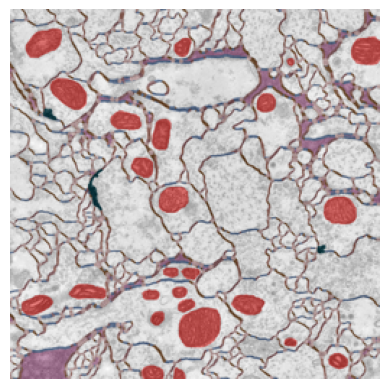

In [2]:
import matplotlib.pyplot as plt

plt.imshow(im)
plt.axis('off')
plt.show()

## Load Pretrained Neural Network

We import the VGG16 model, a pretrained neural network known for its proficiency in image recognition tasks, with weights initialized from the ImageNet dataset. We then set the model to evaluation mode and freeze all weights to prevent further changes during our operations.

In [3]:
import torchvision.models as models
from torchvision.models import VGG16_Weights

model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

model.eval()
model.requires_grad_(False)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Optimize Image Representation

The `deepdream()` function is designed to optimize an image's representation by performing loss maximization using gradient ascent. By iterating over the image data and adjusting it in the direction that increases the activation of certain layers within a pretrained neural network, this function effectively "dreams up" new visual patterns and textures that amplify the features those layers detect. The process involves normalizing the image data (VGG16 is pretrained on the ImageNet dataset and the inputs are normalized wih respect to the mean and standard deviation of the channels of this dataset), applying forward hooks to capture layer activations, calculating the loss, and then updating the image based on the gradients obtained. The result is an altered image that highlights the intricate patterns learned by the neural network.

For doing this, we'll need a class to enable the context management of the forward hooks, which we add to `fc_deepdream.py`:

```python
class fwd_hooks():
    def __init__(self, layers):
        self.layers = layers
        self.hook = []
        self.activations = []
        for layer in self.layers:
            self.hook.append(layer.register_forward_hook(self.hook_func))

    def hook_func(self, layer, input, output):
        self.activations.append(output)

    def __enter__(self, *args): 
         return self
    
    def __exit__(self, *args): 
        for h in self.hook:    
            h.remove()
```

We also add to `fnc_deepdream.py` two functions to transform images to tensors, and vice versa.

The `image_to_tensor()` function preprocess the image by converting to tensor and normalizing the image.
```python
def image_to_tensor(im, mean, std):
    import torchvision.transforms as tt

    normalize = tt.Compose([tt.ToTensor(), tt.Normalize(mean, std)])

    return normalize(im).unsqueeze(0).requires_grad_(True)
```

The `tensor_to_image()` function postprocesses the tensor converting it back to the image format.

```python
def tensor_to_image(image, mean, std):
    import torchvision.transforms as tt
    import numpy as np
    from PIL import Image

    denormalize = tt.Normalize(mean=-mean / std, std=1 / std)

    im_array = denormalize(image.data.clone().detach().squeeze()).numpy()
    im_array = np.clip(im_array.transpose(1, 2, 0) * 255, 0, 255).astype(np.uint8)
    return Image.fromarray(im_array, 'RGB')
```

In [4]:
import numpy as np
import torch
from fnc_deepdream import fwd_hooks, image_to_tensor, tensor_to_image

def deepdream(im, layers, iter_num=100, step=.01):
    # Normalization parameters typically used with pretrained models
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    # Define bounds for normalized image values
    low = torch.tensor((-mean / std).reshape(1, -1, 1, 1))
    high = torch.tensor(((1 - mean) / std).reshape(1, -1, 1, 1))

    im_tensor = image_to_tensor(im, mean, std)
    
    # Perform DeepDream iterations
    for _ in range(iter_num):
        # Forward pass through the model and collect specified layer activations
        with fwd_hooks(layers) as fh:
            _ = model(im_tensor) # No output is needed, as we just need the hooks obtained from the forward pass

        # Calculate mean activation for each layer and sum them as total loss
        losses = [activation.mean() for activation in fh.activations]
        loss = torch.stack(losses).sum()
        loss.backward()

        # Update the image by gradient ascent and normalize the gradient
        im_tensor.data += step * ((im_tensor.grad.data 
                                   - torch.mean(im_tensor.grad.data)) 
                                   / (torch.std(im_tensor.grad.data) + 1e-8))
        im_tensor.grad.data.zero_()  # Clear gradients for next iteration

        # Clamp the image data to ensure pixel values are valid
        im_tensor.data.clamp_(low, high)

    return tensor_to_image(im_tensor, mean, std)

We'll apply deepdreams to the image, using as output the activations of the first ReLU.

In [5]:
layers = [model.features[1]]

im_deepdream_1 = deepdream(im, layers, iter_num=100, step=.01)

Plot DeepDream

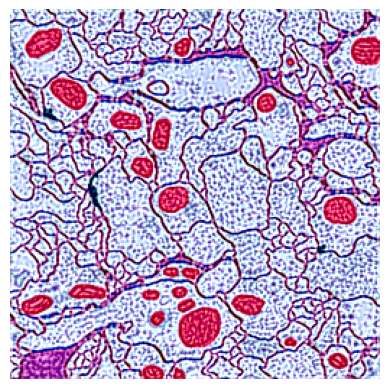

In [6]:
plt.imshow(im_deepdream_1)
plt.axis("off")
plt.show()

By using deeper layer activations, we'll enhance features at larger scales. 

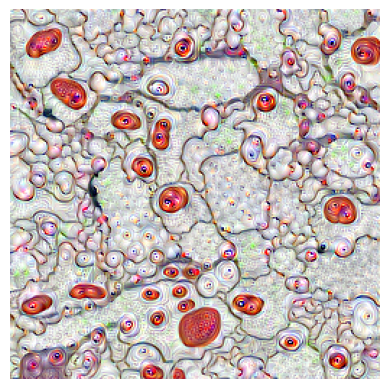

In [7]:
layers = [model.features[18]]

im_deepdream_18 = deepdream(im, layers, iter_num=100, step=.01)

plt.imshow(im_deepdream_18)
plt.axis("off")
plt.show()

We'll combine images at different resolutions using octaves. (This can take a few minutes to complete).

a technique often used in the DeepDream algorithm, which involves processing the image at multiple scales or "octaves". This technique is used to enhance the effects of the DeepDream algorithm by capturing and emphasizing patterns at different levels of granularity. 

Iterative process!

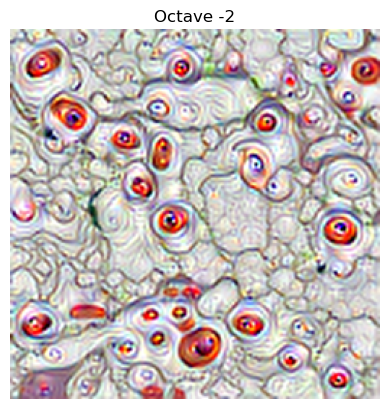

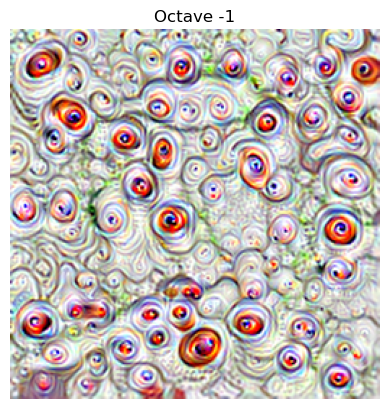

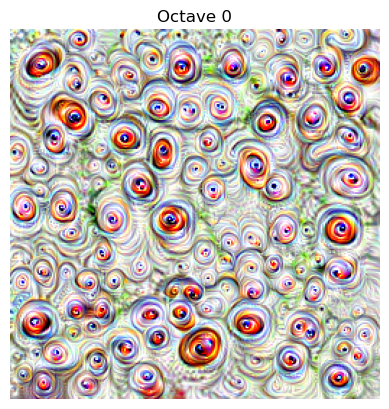

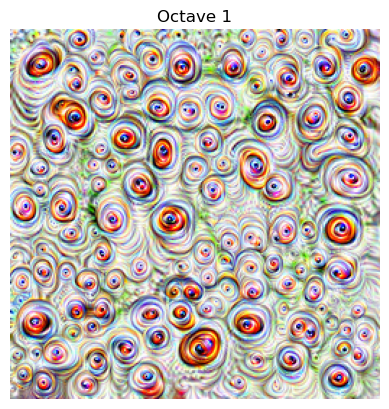

In [8]:
octave_scale = 1.4
layers = [model.features[18]]

original_size = im.size

# Iterate over the range of octaves
im_deepdream = im
for octave in range(-2, 3):
    # Resize the image for the current octave
    new_size = (
        int(original_size[0] * (octave_scale ** octave)), 
        int(original_size[1] * (octave_scale ** octave)),
    )
    im_deepdream = im_deepdream.resize(new_size, Image.LANCZOS)

    # Apply DeepDream to the resized image
    im_deepdream = deepdream(im_deepdream, layers, iter_num=100, step=.01)

    # Resize the processed image back to the original size
    im_deepdream = im_deepdream.resize(original_size, Image.LANCZOS)

    plt.imshow(im_deepdream)
    plt.title(f"Octave {octave}")
    plt.axis('off')
    plt.show()

We can furthermore use the output of several layers simultaneously to enhance multiple features. (This can take a few minutes to complete).

In [ ]:
octave_scale = 1.4

layer_indices = [15, 18, 20, 22, 25, 27, 29]
layers = [model.features[i] for i in layer_indices]

original_size = im.size

# Iterate over the range of octaves
im_deepdream = im
for octave in range(-2, 3):
    # Resize the image for the current octave
    new_size = (
        int(original_size[0] * (octave_scale ** octave)), 
        int(original_size[1] * (octave_scale ** octave)),
    )
    im_deepdream = im_deepdream.resize(new_size, Image.LANCZOS)

    # Apply DeepDream to the resized image
    im_deepdream = deepdream(im_deepdream, layers, iter_num=200, step=.01)

    # Resize the processed image back to the original size
    im_deepdream = im_deepdream.resize(original_size, Image.LANCZOS)

    plt.imshow(im_deepdream)
    plt.title(f"Octave {octave}")
    plt.axis("off")
    plt.show()
